In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
chars = sorted(list(set("".join(words))))

In [5]:
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [6]:
def build_dataset(words):
  block_size = 3
  X,y =[], []
  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      y.append(ix)
      # print(''.join(itos[i] for i in context)," ->" ,itos[ix])
      context = context[1:]+[ix]
  X = torch.tensor(X)
  y = torch.tensor(y)
  print(X.shape,y.shape)
  return X,y

In [7]:
from re import X
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,ytr = build_dataset(words[:n1])
Xdev,ydev = build_dataset(words[n1:n2])
Xte,yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
C = torch.randn((27,2))

In [9]:
emb = C[Xtr]
emb.shape

torch.Size([182625, 3, 2])

In [10]:
emb.view(-1,6).shape

torch.Size([182625, 6])

In [11]:
w1 = torch.randn(6,100)
b1 = torch.randn(100)

In [12]:
h = torch.tanh(emb.view(-1,6) @ w1 + b1)

In [13]:
h.shape

torch.Size([182625, 100])

In [14]:
w2 = torch.randn((100,27))
b2 = torch.randn(27)

In [15]:
logits = h @ w2 + b2

In [16]:
logits.shape

torch.Size([182625, 27])

In [17]:
counts = torch.exp(logits)

In [18]:
counts.shape

torch.Size([182625, 27])

In [19]:
probs = counts / counts.sum(1, keepdims = True)

In [20]:
loss = -probs[torch.arange(Xtr.shape[0]),ytr].log().mean()

In [27]:
g = torch.Generator().manual_seed(2147483647)
# C = torch.randn((27,2), generator = g)
C = torch.ones((27,2))
W1 = torch.randn((6,300), generator = g)
b1 = torch.randn(300, generator = g)
W2 = torch.randn((300,27), generator = g)
b2 = torch.randn(27, generator = g)

In [28]:
params = [C,W1,b1,W2,b2]

In [29]:
for p in params:
  p.requires_grad = True

In [30]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre

In [31]:
lossi = []
stepi = []

In [32]:
num_epoch = 200000
for i in range(num_epoch):
  # mini batch
  ix = torch.randint(0,Xtr.shape[0],(32,))

  # forward
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1,6) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits,ytr[ix])

  # backward
  for p in params:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i<100000 else 0.01
  for p in params:
    p.data += -lr * p.grad

  # track
  lossi.append(loss.log10().item()) # appending log loss to avoid hockey like plot
  stepi.append(i)

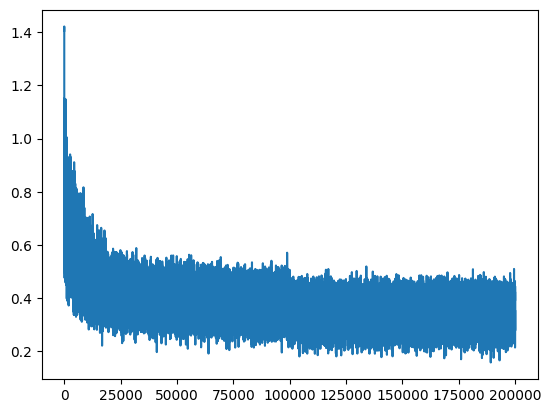

In [33]:
plt.plot(stepi,lossi)

In [34]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,ytr)
loss

tensor(2.2357, grad_fn=<NllLossBackward0>)

In [35]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,6) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits,ydev)
loss

tensor(2.2449, grad_fn=<NllLossBackward0>)

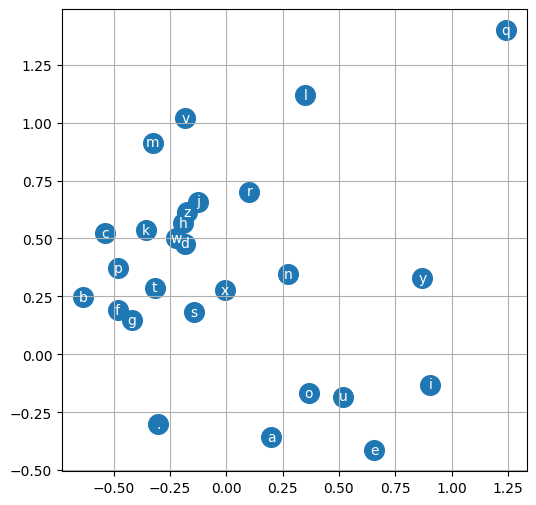

In [36]:
plt.figure(figsize=(6,6))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [40]:
# inference
block_size = 3
context = [0] * block_size
C[torch.tensor([context])].shape
emb = C[context]
emb.view(1,-1).shape

torch.Size([1, 6])

In [48]:
for _ in range(10):
  out = []
  context = [0] * block_size
  while True:
    emb = C[context]
    h = torch.tanh(emb.view(1,-1)@W1 + b1)
    logits = h @ W2 + b2
    prob = F.softmax(logits,1)
    ix = torch.multinomial(prob,1,replacement = True).item()
    out.append(itos[ix])
    context = context[1:]+[ix]
    if ix == 0:
      break
  print(''.join(i for i in out))



kacre.
aviel.
bor.
maristraj.
mirea.
truav.
jiah.
layta.
aulia.
mec.
